In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

data_path = "data/flyvis_data"
cell_type_df = pd.read_csv(f'{data_path}/flyvis_cell_type_connectivity.csv')
outgoing_pert_path = f"{data_path}/moving_edge/outgoing_edge_pert_moving_edge_results"
pair_wise_pert_path = f"{data_path}/moving_edge/pair-wise-pert-moving-edge-results"
motif_pert_path = f"{data_path}/motifs_pert_moving_edge_results"
origianl_network_res = pd.read_csv(f"{data_path}/moving_edge/mv_edge_original_network.csv")

In [ ]:
origianl_network_res.head()

In [ ]:
def get_tc_corr_feature(cell_type: str):
    if cell_type.startswith('T4'):
        return 'tc_correlation_intensity1'
    elif cell_type.startswith('T5'):
        return 'tc_correlation_intensity0'
    else:
        raise ValueError(f"Unknown cell type for tc correlation feature: {cell_type}")


def plot_heat_map(plot_df: pd.DataFrame, title_type='Outgoing'):

    num_rows = len(plot_df)
    fig_height = num_rows * 0.25

    plt.figure(figsize=(10, fig_height)) # Width=10, Height=Dynamic

    # Assuming you are using a heatmap
    ax = sns.heatmap(plot_df, 
                    vmin=plot_df.min().min(),
                    annot=True,       # Show numbers in cells
                    fmt=".2f",        # Format numbers
                    cbar=True,
                    cmap="viridis", 
                    yticklabels=True) # FORCE every row label to be drawn

    # Adjust the font size of the y-axis (row) labels specifically
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8, rotation=0)

    plt.title(f'Magnitude of \'{title_type}-Perturbation\' Impact on TC Correlation', fontsize=16, pad=20)
    plt.xlabel('Target Cell Type', fontsize=12)
    plt.ylabel('Source Cell Type (Perturbed)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    cbar = ax.collections[0].colorbar
    cbar.set_label('Difference (Original - Perturbed)')

    plt.tight_layout()
    plt.show()

def print_top_10(plot_df: pd.DataFrame):

    # 1. Stack the DataFrame to turn it into a long Series with MultiIndex (row, col)
    stacked_data = plot_df.stack()

    # 2. Get the top 10 highest (most positive) values
    top_10 = stacked_data.nlargest(10)

    # 3. Create the list of values
    top_10_values = top_10.tolist()
    top_10_values = [round(val, 3) for val in top_10_values]

    # 4. Create the list of names in format '{src_cell_type}-{cell_type}'
    #    The index of 'top_10' contains tuples like ('Am', 'C3')
    top_10_names = [f"{src}-{target}" for src, target in top_10.index]

    # Print results
    print("Top 10 Values:", top_10_values)
    print("Top 10 Names:", top_10_names)

### outgoing analysis

In [ ]:
# Structure: { 'src_cell_type_name': {'T4a': val, 'T4b': val...} }
results_map = {}

for cell_type in origianl_network_res.cell_type:
    print(f"--- Processing Target: {cell_type} ---")
    ct_origianl = origianl_network_res[origianl_network_res.cell_type == cell_type]
    tc_corr_feature = get_tc_corr_feature(cell_type)
    origial_tc_corr = ct_origianl[tc_corr_feature].values[0]

    for src_cell_type in cell_type_df.source_type.unique():
        if src_cell_type not in results_map:
            results_map[src_cell_type] = {}

        outgoing_df = pd.read_csv(f"{outgoing_pert_path}/{src_cell_type}_outgoing.csv")
        outgoing_ct_df = outgoing_df[outgoing_df.cell_type == cell_type]
        outgoing_corr = outgoing_ct_df[tc_corr_feature].values[0]
        diff_corr = origial_tc_corr - outgoing_corr
        results_map[src_cell_type][cell_type] = diff_corr


diff_results_df = pd.DataFrame.from_dict(results_map, orient='index')
diff_results_df.index.name = 'src_cell_type'
diff_results_df.reset_index(inplace=True)
plot_df = diff_results_df.set_index('src_cell_type')

In [ ]:
plot_heat_map(plot_df)
# print_top_10(plot_df)

### pair - wise analysis

In [ ]:
results_map = {}

for cell_type in origianl_network_res.cell_type:
    print(f"--- Processing Target: {cell_type} ---")
    ct_origianl = origianl_network_res[origianl_network_res.cell_type == cell_type]
    tc_corr_feature = get_tc_corr_feature(cell_type)
    origial_tc_corr = ct_origianl[tc_corr_feature].values[0]

    for pair_file in os.listdir(pair_wise_pert_path):
        pair = pair_file.replace(".csv", "")

        if pair not in results_map:
            results_map[pair] = {}

        df = pd.read_csv(f"{pair_wise_pert_path}/{pair_file}")
        df_ct_df = df[df.cell_type == cell_type]
        df_corr = df_ct_df[tc_corr_feature].values[0]
        diff_corr = origial_tc_corr - df_corr
        results_map[pair][cell_type] = diff_corr


diff_results_df = pd.DataFrame.from_dict(results_map, orient='index')
diff_results_df.index.name = 'src_cell_type'
diff_results_df.reset_index(inplace=True)
plot_df = diff_results_df.set_index('src_cell_type')

In [ ]:
plot_heat_map(plot_df, title_type='Pair-Wise')
print_top_10(plot_df)

** Make heatmap in connected matrix **

In [12]:
from typing import List, Optional, Tuple
from matplotlib.colors import Colormap
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt

In [9]:
def calculate_t4_t5_averages(diff_results_df: pd.DataFrame):
    if 'src_cell_type' in diff_results_df.columns:
        plot_df = diff_results_df.set_index('src_cell_type')
    else:
        plot_df = diff_results_df.copy()
    

    t4_columns = ['T4a', 'T4b', 'T4c', 'T4d']
    t5_columns = ['T5a', 'T5b', 'T5c', 'T5d']
    
    t4_avg_df = plot_df[t4_columns].mean(axis=1).to_frame(name='T4_avg')
    t5_avg_df = plot_df[t5_columns].mean(axis=1).to_frame(name='T5_avg')
    
    t4_avg_df = t4_avg_df.reset_index()
    t5_avg_df = t5_avg_df.reset_index()
    
    return t4_avg_df, t5_avg_df

In [ ]:
t4_avg_df, t5_avg_df = calculate_t4_t5_averages(diff_results_df)

print("\nAverage impact on T4 cell types:")
print(t4_avg_df.head())
print(f"\nShape: {t4_avg_df.shape}")

print("\nAverage impact on T5 cell types:")
print(t5_avg_df.head())
print(f"\nShape: {t5_avg_df.shape}")


Average impact on T4 cell types:
  src_cell_type        T4_avg
0         Am_C2  4.129403e-08
1         Am_C3  0.000000e+00
2         Am_L1  3.544124e-08
3         Am_L2 -6.235701e-09
4         Am_L3  4.435426e-08

Shape: (805, 2)

Average impact on T5 cell types:
  src_cell_type        T5_avg
0         Am_C2 -1.090787e-08
1         Am_C3  0.000000e+00
2         Am_L1  4.174098e-09
3         Am_L2  8.737123e-09
4         Am_L3 -1.195744e-08

Shape: (805, 2)


In [25]:
def create_perturbation_matrix(
    perturbation_df: pd.DataFrame,
    target_column: str,
    cell_types_sorted: List[str],
    title: str,
    cbar_label: str,
    plots_module,
    cmap: Optional[Colormap] = None,
    figsize: Tuple[float, float] = (12, 10),
    **kwargs
):
    """Create a connectivity-style matrix showing perturbation impacts."""
    if 'src_cell_type' not in perturbation_df.columns:
        pert_df = perturbation_df.reset_index()
    else:
        pert_df = perturbation_df.copy()
    
    # Convert numpy strings to regular Python strings for matching
    cell_types_sorted_str = [str(ct) for ct in cell_types_sorted]
    type_index = {cell_type: i for i, cell_type in enumerate(cell_types_sorted_str)}
    
    matrix = np.zeros([len(type_index), len(type_index)])
    
    matches = 0
    for _, row in pert_df.iterrows():
        src_type = str(row['src_cell_type'])
        
        # Check for underscore separator (your format: "Am_C2")
        if '_' in src_type:
            src_parts = src_type.split('_')
            if len(src_parts) == 2:
                src_cell, tgt_cell = src_parts
                if src_cell in type_index and tgt_cell in type_index:
                    matrix[type_index[src_cell], type_index[tgt_cell]] = row[target_column]
                    matches += 1
        # Also check for hyphen separator (in case format varies: "Am-C2")
        elif '-' in src_type:
            src_parts = src_type.split('-')
            if len(src_parts) == 2:
                src_cell, tgt_cell = src_parts
                if src_cell in type_index and tgt_cell in type_index:
                    matrix[type_index[src_cell], type_index[tgt_cell]] = row[target_column]
                    matches += 1
    
    print(f"  Matched {matches} perturbations to connectome structure")
    
    # Replace zeros with NaN for cleaner visualization
    matrix[matrix == 0] = np.nan
    
    plot_kwargs = dict(
        symlog=1e-5,
        grid_linewidth=0.5,
        cmap=cmap or cm.get_cmap("seismic"),
        title=title,
        cbar_label=cbar_label,
        size_scale=0.05,
        figsize=figsize,
        fontsize=5,
        cbar=True,
        origin='upper',
    )
    plot_kwargs.update(kwargs)
    
    fig, ax, cbar_obj, matrix = plots_module.heatmap(
        matrix, 
        xlabels=cell_types_sorted_str,
        ylabels=cell_types_sorted_str,
        **plot_kwargs
    )
    
    ax.set_xlabel('Target Cell Type (Perturbed Connection To)', fontsize=8)
    ax.set_ylabel('Source Cell Type (Perturbed Connection From)', fontsize=8)
    
    return fig, ax, cbar_obj, matrix

In [27]:
def plot_t4_t5_perturbation_matrices(
    diff_results_df: pd.DataFrame,
    cell_types_sorted: List[str],
    plots_module,
    figsize: Tuple[float, float] = (12, 10),
    **kwargs
):
    """
    Create both T4 and T5 perturbation matrices.
    
    Parameters:
    -----------
    diff_results_df : pd.DataFrame
        DataFrame with pairwise perturbation results including T4_avg and T5_avg columns
    cell_types_sorted : List[str]
        Ordered list of cell types from ConnectomeView
    plots_module : module
        The flyvis plots module (from flyvis.analysis.visualization import plots)
    figsize : Tuple[float, float]
        Figure size for each plot
    **kwargs : dict
        Additional arguments passed to create_perturbation_matrix
        
    Returns:
    --------
    Tuple : (T4 figure outputs, T5 figure outputs) 
            Each is a tuple of (fig, ax, cbar_obj, matrix)
    """
    # Calculate T4 and T5 averages if not already present
    if 'T4_avg' not in diff_results_df.columns:
        diff_results_df['T4_avg'] = diff_results_df[['T4a', 'T4b', 'T4c', 'T4d']].mean(axis=1)
    if 'T5_avg' not in diff_results_df.columns:
        diff_results_df['T5_avg'] = diff_results_df[['T5a', 'T5b', 'T5c', 'T5d']].mean(axis=1)
    
    # Create T4 matrix
    t4_outputs = create_perturbation_matrix(
        perturbation_df=diff_results_df,
        target_column='T4_avg',
        cell_types_sorted=cell_types_sorted,
        title='Impact of Pairwise Perturbations on T4 Cell Types (Average)',
        cbar_label=r'$\Delta$ TC Correlation (Original - Perturbed)',
        plots_module=plots_module,
        figsize=figsize,
        **kwargs
    )
    
    # Create T5 matrix
    t5_outputs = create_perturbation_matrix(
        perturbation_df=diff_results_df,
        target_column='T5_avg',
        cell_types_sorted=cell_types_sorted,
        title='Impact of Pairwise Perturbations on T5 Cell Types (Average)',
        cbar_label=r'$\Delta$ TC Correlation (Original - Perturbed)',
        plots_module=plots_module,
        figsize=figsize,
        **kwargs
    )
    
    return t4_outputs, t5_outputs

In [22]:
from flyvis import connectome_file
from flyvis.connectome import ConnectomeView, ConnectomeFromAvgFilters
from flyvis.analysis.visualization import plots
from typing import List, Optional, Tuple
from matplotlib.colors import Colormap
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import pandas as pd

  Matched 604 perturbations to connectome structure
  Matched 604 perturbations to connectome structure


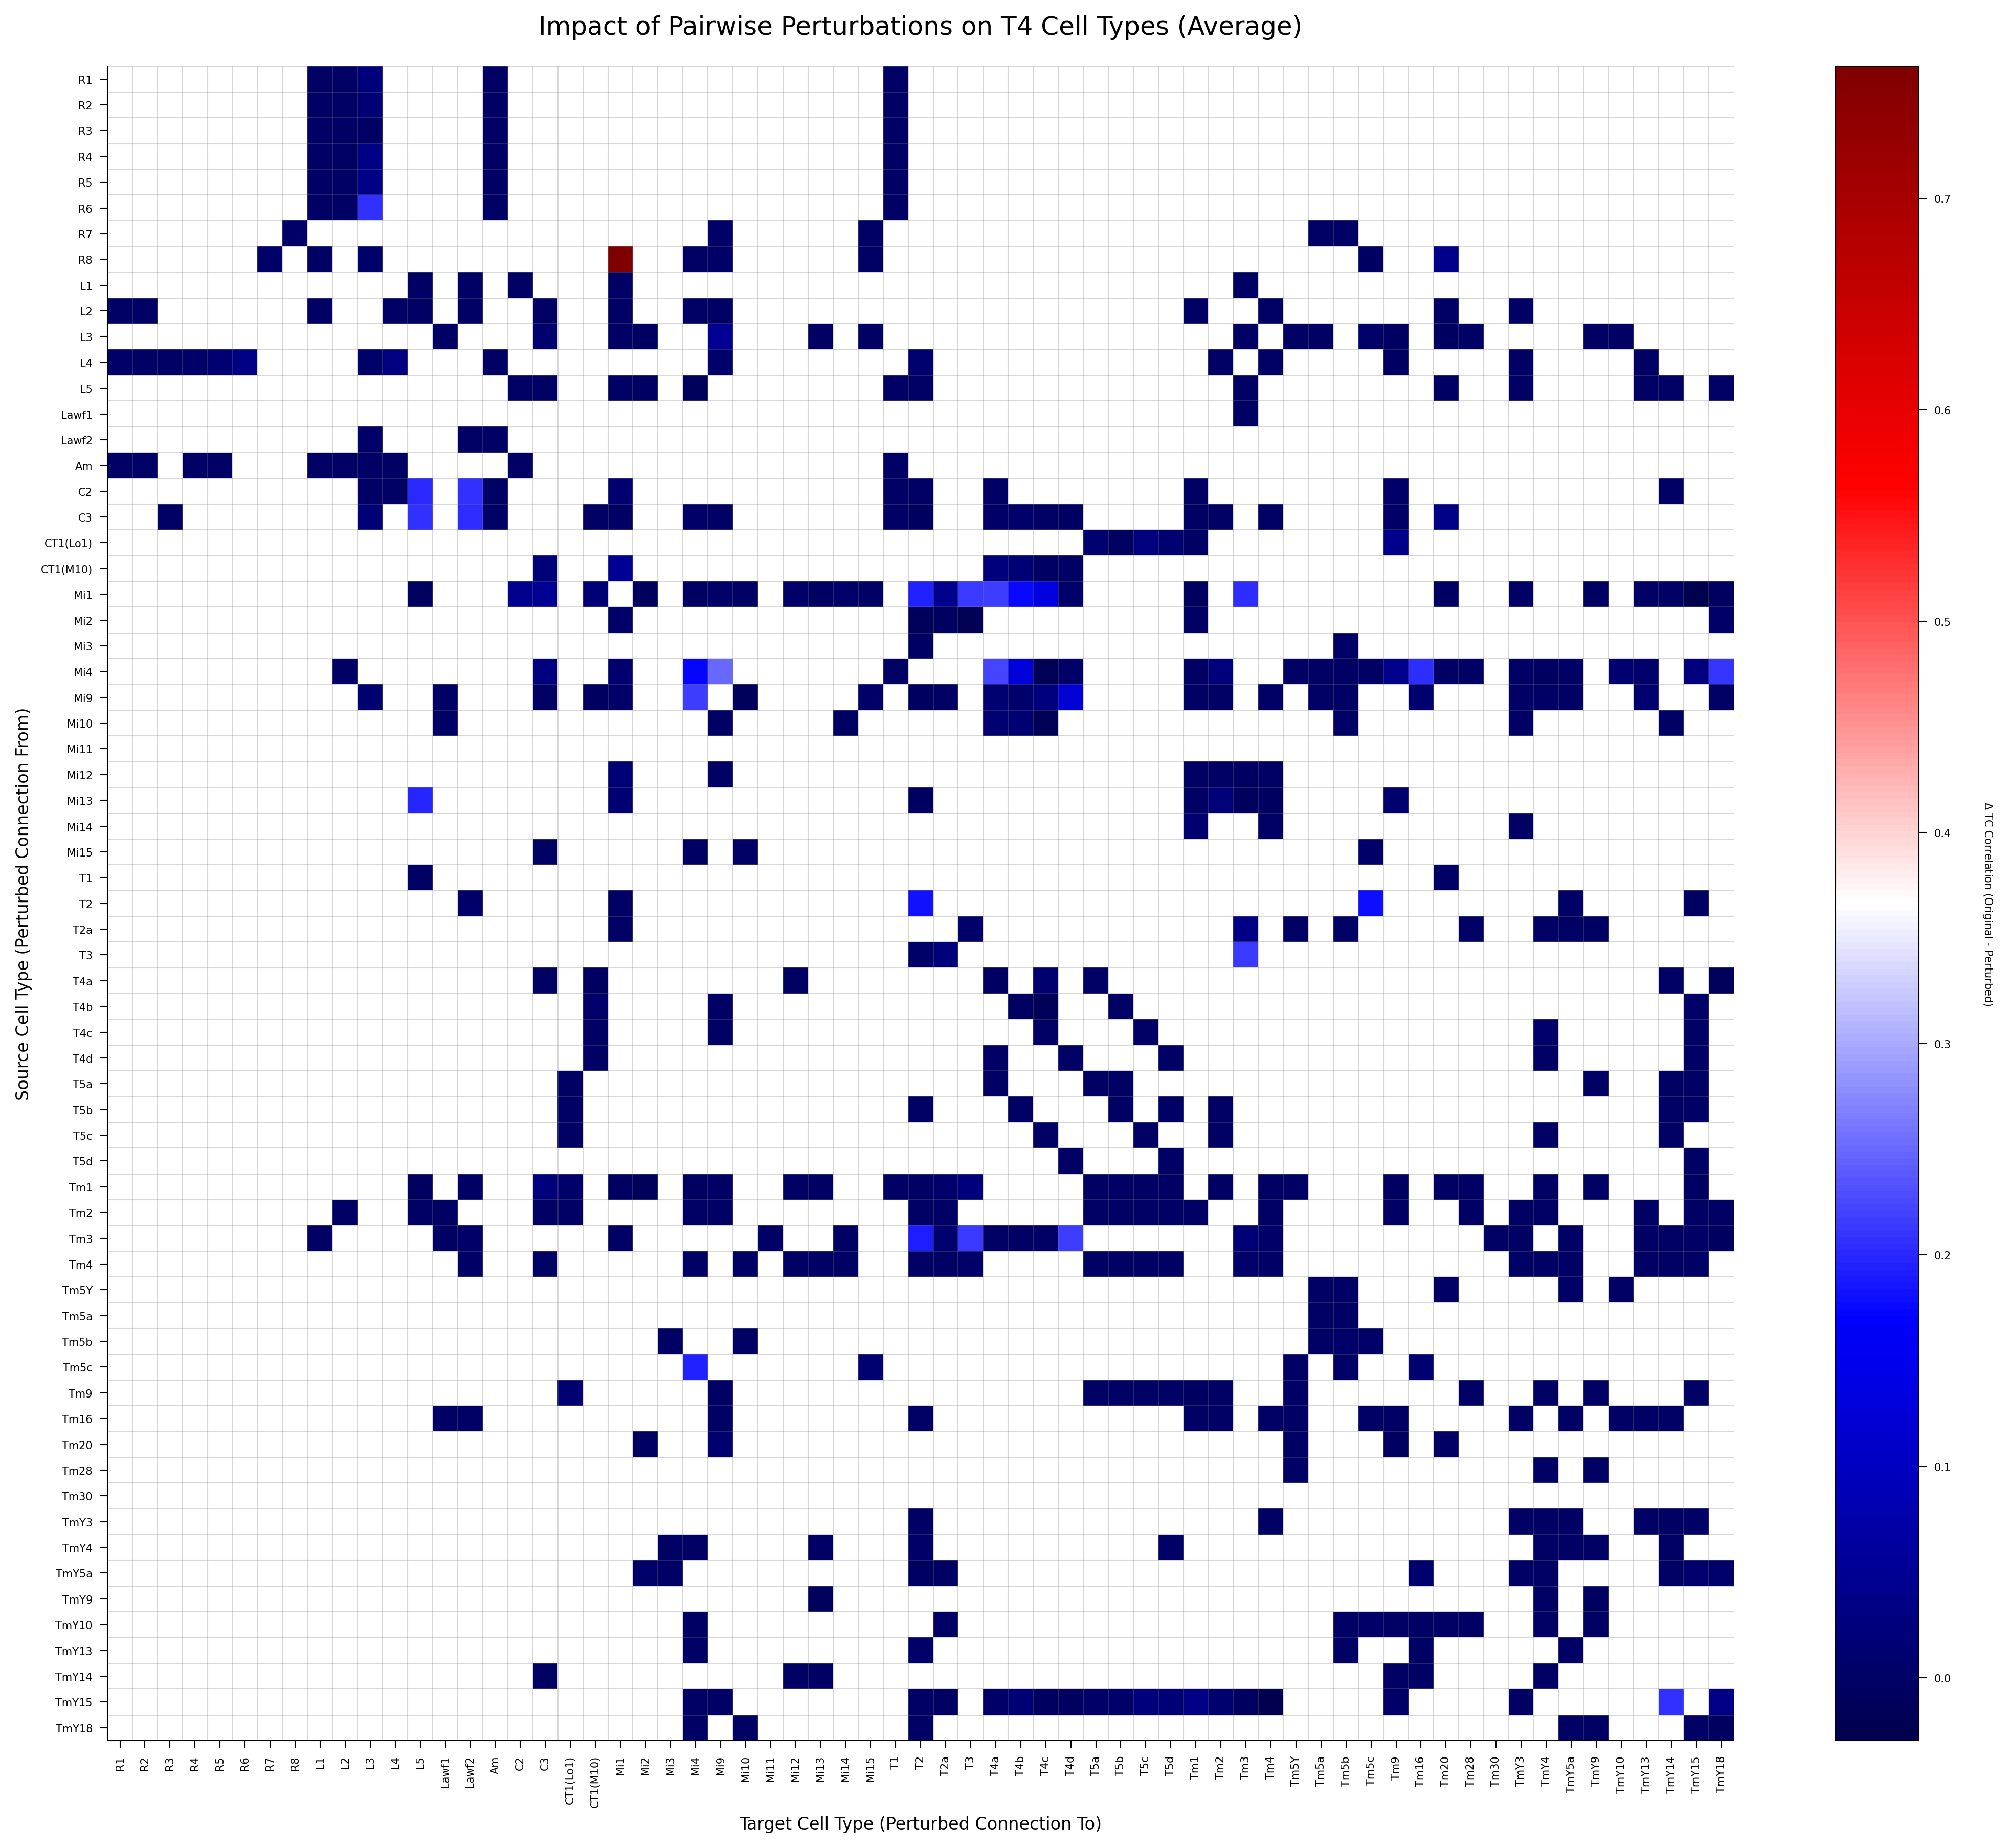

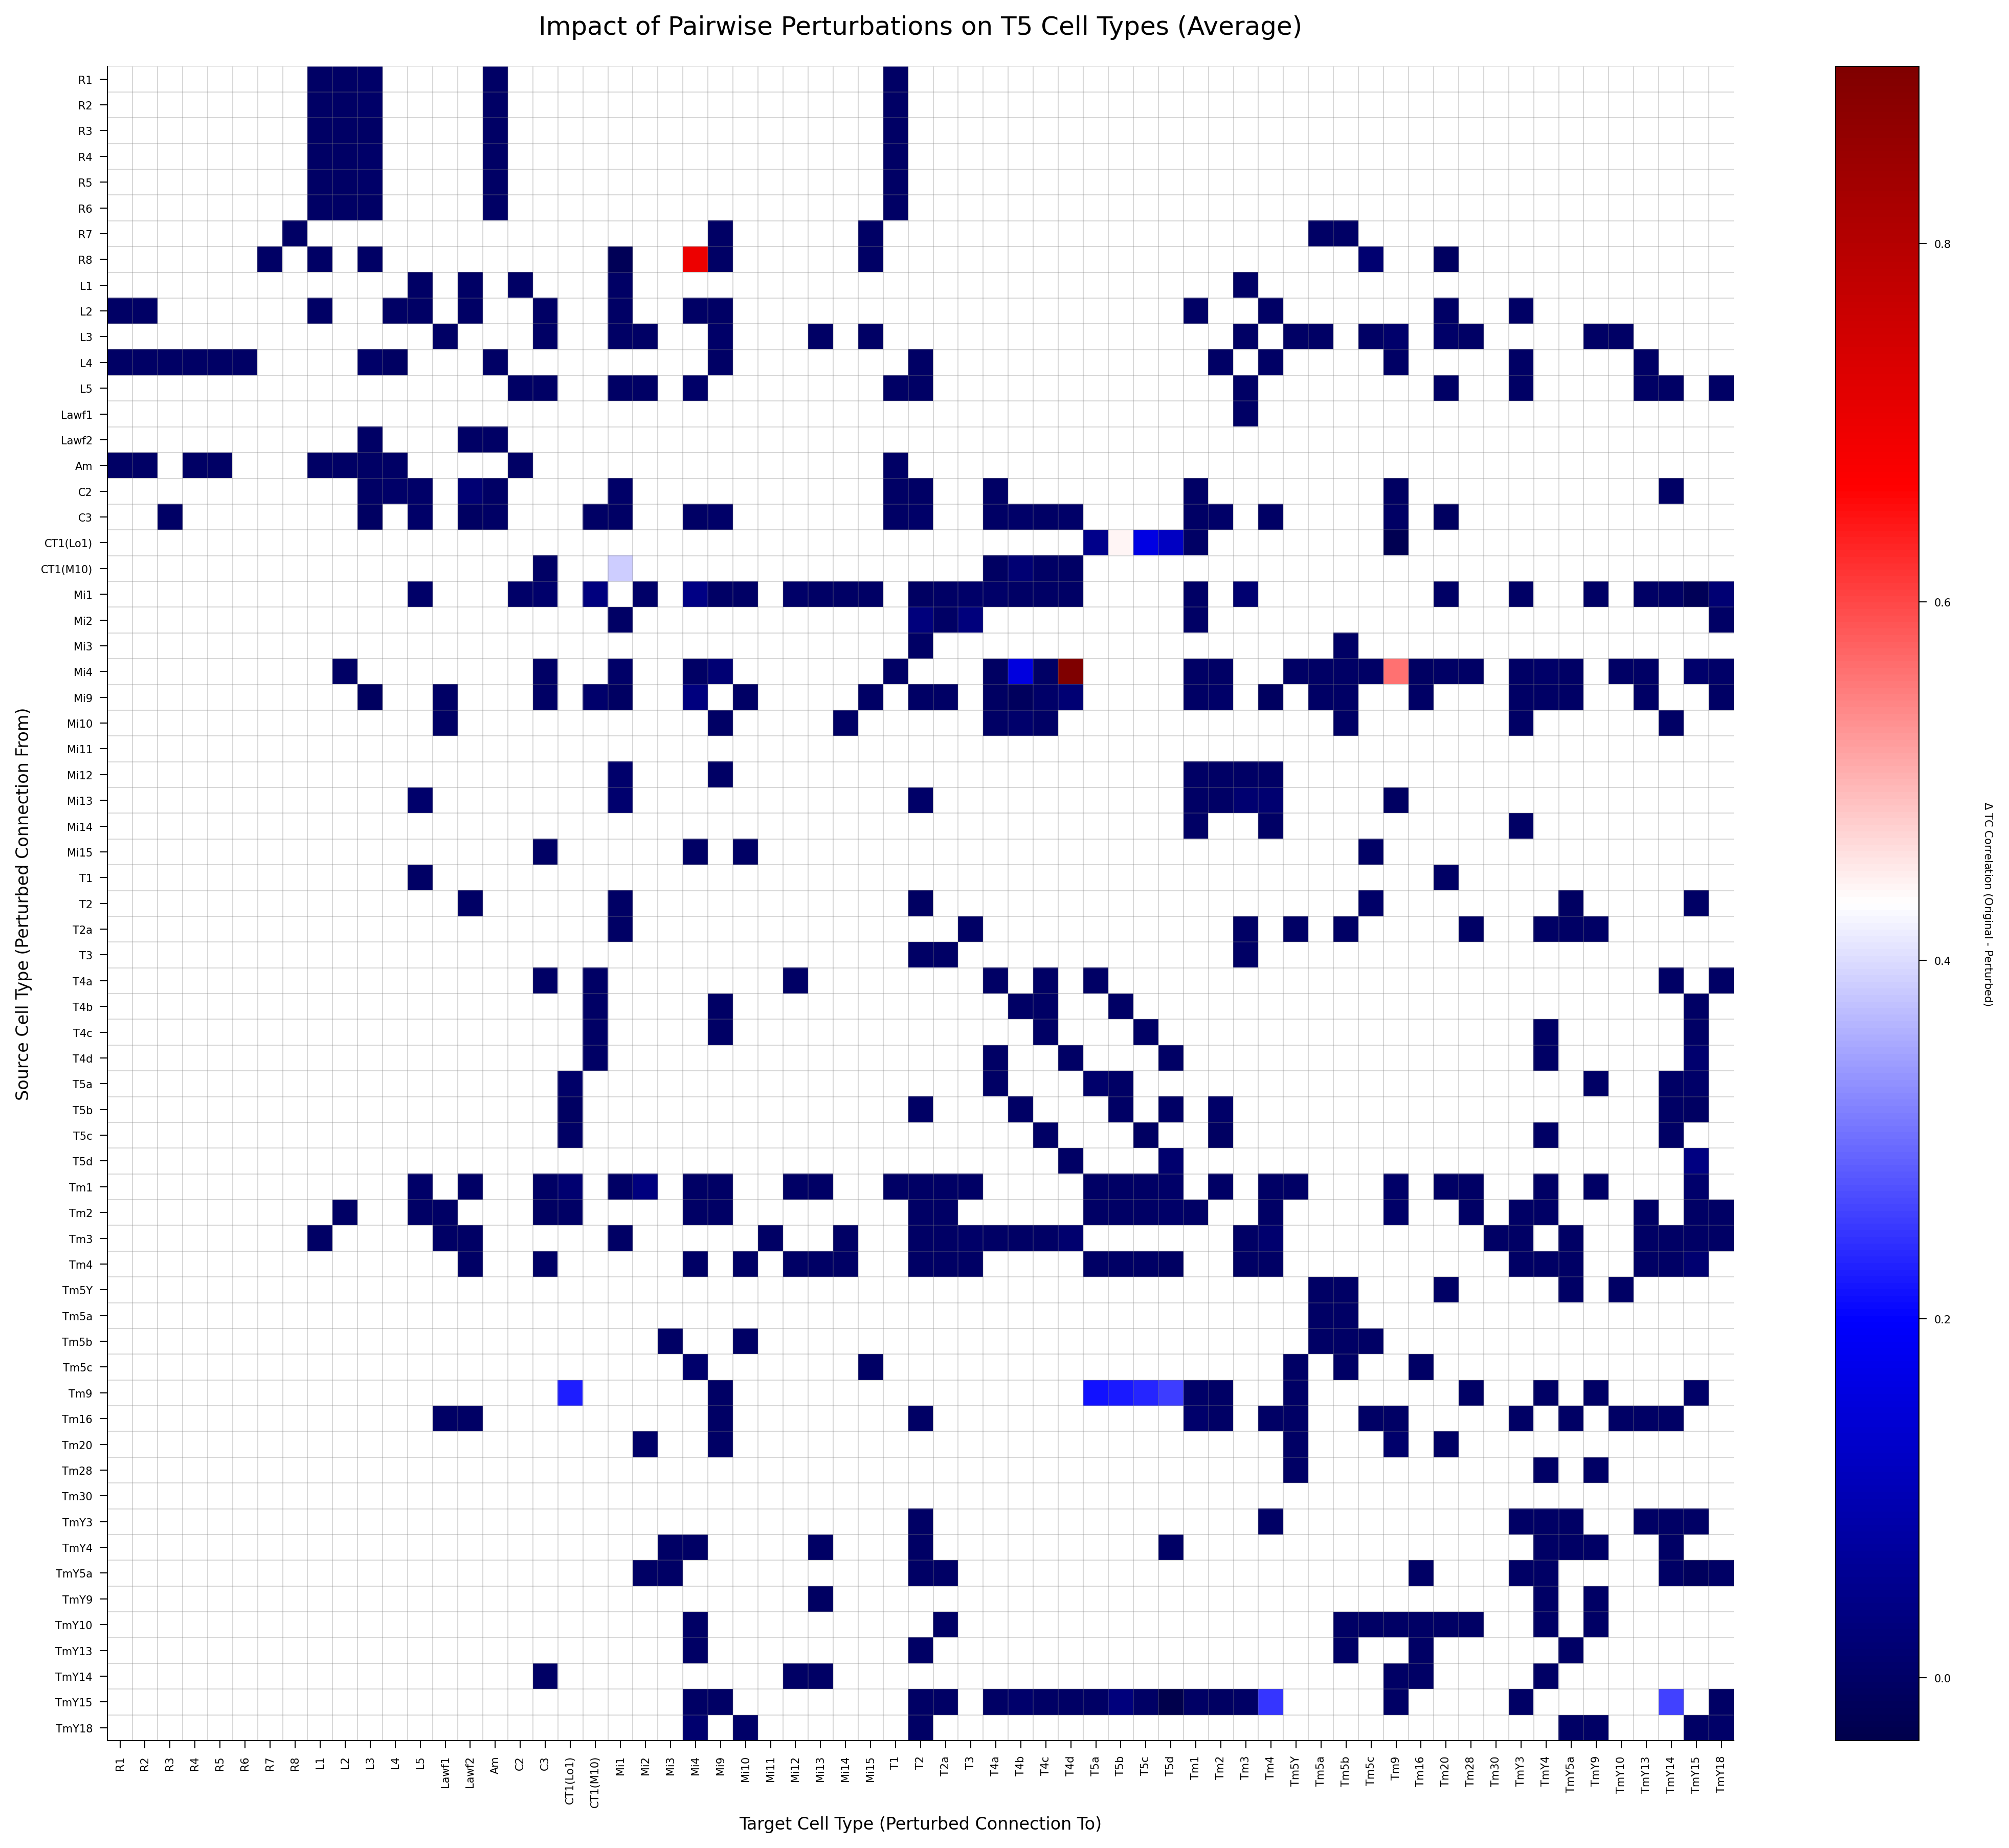


T4 matrix non-NaN values: 578
T4 matrix range: [-2.98e-02, 7.63e-01]

T5 matrix non-NaN values: 578
T5 matrix range: [-3.51e-02, 8.99e-01]


In [32]:
def create_perturbation_matrix_imshow(
    perturbation_df: pd.DataFrame,
    target_column: str,
    cell_types_sorted: List[str],
    title: str,
    cbar_label: str,
    figsize: Tuple[float, float] = (14, 12),
    cmap=None,
    **kwargs
):
    """Create a standard imshow-style heatmap (not scatter-based)."""
    if 'src_cell_type' not in perturbation_df.columns:
        pert_df = perturbation_df.reset_index()
    else:
        pert_df = perturbation_df.copy()
    
    # Convert numpy strings to regular Python strings
    cell_types_sorted_str = [str(ct) for ct in cell_types_sorted]
    type_index = {cell_type: i for i, cell_type in enumerate(cell_types_sorted_str)}
    
    matrix = np.zeros([len(type_index), len(type_index)])
    
    matches = 0
    for _, row in pert_df.iterrows():
        src_type = str(row['src_cell_type'])
        
        if '_' in src_type:
            src_parts = src_type.split('_')
            if len(src_parts) == 2:
                src_cell, tgt_cell = src_parts
                if src_cell in type_index and tgt_cell in type_index:
                    matrix[type_index[src_cell], type_index[tgt_cell]] = row[target_column]
                    matches += 1
    
    print(f"  Matched {matches} perturbations to connectome structure")
    
    # Replace zeros with NaN
    matrix[matrix == 0] = np.nan
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Use imshow instead of scatter
    im = ax.imshow(matrix, cmap=cmap or plt.cm.seismic, aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(cell_types_sorted_str)))
    ax.set_yticks(np.arange(len(cell_types_sorted_str)))
    ax.set_xticklabels(cell_types_sorted_str, rotation=90, fontsize=5)
    ax.set_yticklabels(cell_types_sorted_str, fontsize=5)
    
    # Add grid
    ax.set_xticks(np.arange(len(cell_types_sorted_str))-.5, minor=True)
    ax.set_yticks(np.arange(len(cell_types_sorted_str))-.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label, rotation=270, labelpad=20)
    
    # Labels and title
    ax.set_xlabel('Target Cell Type (Perturbed Connection To)', fontsize=8)
    ax.set_ylabel('Source Cell Type (Perturbed Connection From)', fontsize=8)
    ax.set_title(title, fontsize=12, pad=15)
    
    plt.tight_layout()
    
    return fig, ax, cbar, matrix


# Use imshow version
fig_t4, ax_t4, cbar_t4, matrix_t4 = create_perturbation_matrix_imshow(
    perturbation_df=diff_results_df,
    target_column='T4_avg',
    cell_types_sorted=cell_types_sorted,
    title='Impact of Pairwise Perturbations on T4 Cell Types (Average)',
    cbar_label=r'$\Delta$ TC Correlation (Original - Perturbed)',
    figsize=(14, 12)
)

fig_t5, ax_t5, cbar_t5, matrix_t5 = create_perturbation_matrix_imshow(
    perturbation_df=diff_results_df,
    target_column='T5_avg',
    cell_types_sorted=cell_types_sorted,
    title='Impact of Pairwise Perturbations on T5 Cell Types (Average)',
    cbar_label=r'$\Delta$ TC Correlation (Original - Perturbed)',
    figsize=(14, 12)
)

plt.show()

# Print some diagnostics
print(f"\nT4 matrix non-NaN values: {np.sum(~np.isnan(matrix_t4))}")
print(f"T4 matrix range: [{np.nanmin(matrix_t4):.2e}, {np.nanmax(matrix_t4):.2e}]")
print(f"\nT5 matrix non-NaN values: {np.sum(~np.isnan(matrix_t5))}")
print(f"T5 matrix range: [{np.nanmin(matrix_t5):.2e}, {np.nanmax(matrix_t5):.2e}]")

### Motifs analysis

In [ ]:
# Structure: { 'src_cell_type_name': {'T4a': val, 'T4b': val...} }
results_map = {}

for cell_type in origianl_network_res.cell_type:
    print(f"--- Processing Target: {cell_type} ---")
    ct_origianl = origianl_network_res[origianl_network_res.cell_type == cell_type]
    tc_corr_feature = get_tc_corr_feature(cell_type)
    origial_tc_corr = ct_origianl[tc_corr_feature].values[0]

    for file in os.listdir(motif_pert_path):
        motif = file.replace(".csv", "")

        if motif not in results_map:
            results_map[motif] = {}

        # Load the pair-wise perturbation data
        try:
            df = pd.read_csv(f"{motif_pert_path}/{file}")
            df_ct_df = df[df.cell_type == cell_type]
            df_corr = df_ct_df[tc_corr_feature].values[0]
            diff_corr = (origial_tc_corr - df_corr)
            results_map[motif][cell_type] = diff_corr
        except FileNotFoundError:
            print(f"File not found for source: {src_cell_type}")
            results_map[src_cell_type][cell_type] = None

# 3. Convert the dictionary to the desired DataFrame
# orient='index' makes the dictionary keys (src_cell_type) the rows
diff_results_df = pd.DataFrame.from_dict(results_map, orient='index')

# 4. Clean up: Move the index (src_cell_type) to a proper column
diff_results_df.index.name = 'src_cell_type'
diff_results_df.reset_index(inplace=True)

In [ ]:
if 'src_cell_type' in diff_results_df.columns:
    plot_df = diff_results_df.set_index('src_cell_type')
else:
    # Assuming src_cell_type is already the index if the column doesn't exist
    plot_df = diff_results_df.copy()


In [ ]:
origianl_network_res

In [ ]:
df = pd.read_csv(f"{motif_pert_path}/{os.listdir(motif_pert_path)[0]}")
df

In [ ]:
plot_heat_map(plot_df, title_type='Motif')
print_top_10(plot_df)

### Motifs Feedback analysis

In [ ]:
origianl_network_res_feedback.head()

In [ ]:
def feed_back_plot(dir_, intensity= 0.75):

    results_map = {}

    for cell_type in origianl_network_res_feedback.cell_type:
        print(f"--- Processing Target: {cell_type} ---")
        ct_origianl = origianl_network_res_feedback[origianl_network_res_feedback.cell_type == cell_type]
        tc_corr_feature = f'tc_correlation_intensity{intensity}'
        origial_tc_corr = ct_origianl[tc_corr_feature].values[0]

        for pattern in os.listdir(f'{feedback_path}/{dir_}'):
            pattern = str(pattern)
            df = pd.read_csv(f'{feedback_path}/{dir_}/{pattern}/res.csv')

            if pattern not in results_map:
                results_map[pattern] = {}

            df_ct_df = df[df.cell_type == cell_type]
            df_corr = df_ct_df[tc_corr_feature].values[0]
            diff_corr = origial_tc_corr - df_corr
            results_map[pattern][cell_type] = diff_corr

    diff_results_df = pd.DataFrame.from_dict(results_map, orient='index')
    diff_results_df.index.name = 'src_cell_type'
    diff_results_df.reset_index(inplace=True)
    plot_df = diff_results_df.set_index('src_cell_type')

    plot_heat_map(plot_df, title_type=f'{dir_}')

In [ ]:
for dir_ in os.listdir(feedback_path):
    if dir_ == 'original':
        continue
    feed_back_plot(dir_)

In [ ]:
for dir_ in os.listdir(feedback_path):
    if dir_ == 'original':
        continue
    feed_back_plot(dir_, intensity=0.0)